In [1]:
import os
import gc
import csv
import sys
import time
import h5py
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import nibabel as nib
from nilearn import image, surface, plotting, datasets

from sklearn.metrics import pairwise_distances
import scipy.sparse as sps
import scipy as sp
from scipy.sparse.linalg import eigsh, eigs
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.pyplot import MultipleLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
from scipy.stats import pearsonr
import pickle 

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['ps.usedistiller'] = 'xpdf'
from matplotlib import font_manager
font_manager.fontManager.addfont("/n02dat01/users/lchai/anaconda3/envs/Nm/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/arial.ttf")
plt.rcParams["font.sans-serif"] = "Arial" 

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/n01dat01/dyli/env/miniconda3/envs/yfpy/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
_ = np.array([0, 2, 12, 14, 16, 18, 20, 22, 24, 26, 29, 31, 33, 35, 37, 39, 41, 43, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 4, 5, 6, 7, 8, 9, 10, 11, 28, 45])
# read the fiber name
l_idx = [1,3,13,15,17,19,25,27,30,32,36,38,40,42,44,47,49,51,53,55,57,59,61,63,65,67,69,71]
r_idx = [2,4,14,16,18,24,26,28,31,35,37,39,41,43,45,48,50,52,54,56,58,60,62,64,66,68,70,72]
m_idx = [4,5,6,7,8,9,10,11]
l_idx = np.array(l_idx)
r_idx = np.array(r_idx)
m_idx = np.array(m_idx)
l_idx = l_idx-1
r_idx = r_idx-1
label_f = open('/n02dat01/users/dyli/Grad_data/support_data/fiber_name_ori_nonum_nohemi.txt', 'r')
label_name = label_f.readlines()
label_name = [' '.join([i.strip() for i in price.strip().split('\n')]) for price in label_name]
label_name_lm = [label_name[l_idx[i]] for i in range(len(l_idx))] + [label_name[m_idx[i]] for i in range(len(m_idx))]
print(f'the number of fiber: {len(label_name_lm)}')

new_fiber_idx = []
for fi,ff in enumerate(_):
    if ff in list(l_idx)+list(m_idx): new_fiber_idx.append(fi)
new_fiber_idx = np.array(new_fiber_idx)
print(new_fiber_idx.shape)

the number of fiber: 36
(36,)


In [3]:
len(label_name_lm)

36

In [4]:
# the medial wall
dirc_L = '/n02dat01/users/dyli/Atlas/metric_index_L.txt'
select_ind_L = np.loadtxt( dirc_L ).astype(int)
dirc_R = '/n02dat01/users/dyli/Atlas/metric_index_R.txt'
select_ind_R = np.loadtxt( dirc_R ).astype(int)

Firstly, we calculate the high-low frequency ratio for each tract in HCP and IMAGEN

ref link: https://doi.org/10.1038/s41467-019-12765-7 

ref title: Decoupling of brain function from structure reveals regional behavioral specialization in humans 

The cut frequency is calculated by figure4_freq_ratio.m

* HCP

In [5]:
exp_name = '1200'

# read the sublist
list_path = '/n01dat01/dyli/multi/scripts/data_preprocess/sub_list/HCP_968.txt'
with open( list_path, 'r' ) as f:
    namelist = [ str( line.strip()) for line in f.readlines() ]
print(f'the sub num is {len(namelist)}')

# remove the medial wall
dirc_L = '/n02dat01/users/dyli/Atlas/metric_index_L.txt'
select_ind_L = np.loadtxt( dirc_L ).astype(int)
dirc_R = '/n02dat01/users/dyli/Atlas/metric_index_R.txt'
select_ind_R = np.loadtxt( dirc_R ).astype(int)

St = np.zeros((32492, 36)) # (32492, 36)
for sub in tqdm(namelist):
    # read the fingerprint
    _ = sps.load_npz(f'/n04dat01/atlas_group/lma/HCP_test_retest/MSM/HCP_{exp_name}/{sub}/{sub}_L_probtrackx_omatrix2/finger_print_fiber_MSMALL.npz')
    _ = _.toarray()

    # check the all-zero row
    for ii in range(_.shape[0]):
        if len(np.unique(_[ii,:])) == 1: _[ii,:]=_[ii-1,:]
    for ii in range(_.shape[0]):
        if len(np.unique(_[ii,:])) == 1: sys.exit() 

    # normalization
    fingerprint = np.array([_[:,i]/np.sum(_, axis=1) for i in range(_.shape[1])]).T

    # choose the left fibers and the cc fibers
    fingerprint = fingerprint[:, np.array(list(l_idx) + list(m_idx))]
    assert fingerprint.shape[0]==29696 and fingerprint.shape[1]==int(len(l_idx)+len(m_idx))

    St[select_ind_L, :] += fingerprint
St = St/len(namelist)
np.savetxt(f'/n01dat01/dyli/multi/results_data/HCP_{exp_name}_fingerprint_mean.txt', St)

the sub num is 40


100%|██████████| 40/40 [00:41<00:00,  1.04s/it]


In [6]:
exp_name = '1200'
surface_name = 'white'

'''
decide the cut frequency C: based on average energy spectral density
'''
# read the group MODE
U = np.loadtxt(f'/n01dat01/dyli/multi/support_code/BrainEigenmodes/data/template_eigenmodes/fsLR_32k_{surface_name}-lh_emode_200.txt') # (32492, 200)
# read the group lambda
lam = np.loadtxt(f'/n01dat01/dyli/multi/support_code/BrainEigenmodes/data/template_eigenmodes/fsLR_32k_{surface_name}-lh_eval_200.txt') # (200,)
C_idx = int(8)

'''
Graph signal filtering was implemented in order to decompose the functional signal into one part well coupled with structure 
(i.e., represented by low-frequency eigenmodes of the graph) and one that is less coupled (i.e., by higher-frequency eigenmodes).  
'''
print('calculating the decoupling index...')
U_low  = U.copy() # (32492, 200)
U_high = U.copy() # (32492, 200)
for _i in range(U.shape[1]):
    if _i <= C_idx: U_high[:,_i] = np.zeros(32492) # 高频U低频置零
    elif _i> C_idx: U_low[:, _i] = np.zeros(32492)
St     = np.loadtxt(f'/n01dat01/dyli/multi/results_data/HCP40_{exp_name}_fingerprint_mean.txt') # (32492, 36)
StC    = np.dot(np.dot(U_low, U.T), St) # (32492, 36)
StD    = np.dot(np.dot(U_high,U.T), St) # (32492, 36)
CDindex= np.abs(StD) / (np.abs(StC)+0.1) # (32492, 36)

print('saving the results...')
np.save(f'/n01dat01/dyli/multi/results_data/decoupling_index/HCP_{surface_name}_{exp_name}_NC_C_{C_idx}.npy', StC)
np.save(f'/n01dat01/dyli/multi/results_data/decoupling_index/HCP_{surface_name}_{exp_name}_NC_D_{C_idx}.npy', StD)
np.save(f'/n01dat01/dyli/multi/results_data/decoupling_index/HCP_{surface_name}_{exp_name}_NC_CDindex_{C_idx}.npy', CDindex)

calculating the decoupling index...
saving the results...


* Baseline

In [9]:
age_name = 'BL'
print(age_name)
'''
decide the cut frequency C: based on average energy spectral density
'''
# read the group MODE
U = np.loadtxt(f'/n01dat01/dyli/multi/support_code/BrainEigenmodes/data/template_eigenmodes/{age_name}_fsLR_32k_{surface_name}-lh_emode_200.txt') # (32492, 200)
# read the group lambda
lam = np.loadtxt(f'/n01dat01/dyli/multi/support_code/BrainEigenmodes/data/template_eigenmodes/{age_name}_fsLR_32k_{surface_name}-lh_eval_200.txt') # (200,)
C_idx = int(8)

'''
Graph signal filtering was implemented in order to decompose the functional signal into one part well coupled with structure 
(i.e., represented by low-frequency eigenmodes of the graph) and one that is less coupled (i.e., by higher-frequency eigenmodes).  
'''
print('calculating the decoupling index...')
U_low  = U.copy() # (32492, 200)
U_high = U.copy() # (32492, 200)
for _i in range(U.shape[1]):
    if _i <= C_idx: U_high[:,_i] = np.zeros(32492) # 高频U低频置零
    elif _i> C_idx: U_low[:, _i] = np.zeros(32492)
St     = np.loadtxt(f'/n01dat01/dyli/multi/results_data/{age_name}_fingerprint_mean_v3.txt') # (32492, 36)
StC    = np.dot(np.dot(U_low, U.T), St) # (32492, 36)
StD    = np.dot(np.dot(U_high,U.T), St) # (32492, 36)
CDindex= np.abs(StD) / (np.abs(StC)+0.1) # (32492, 36)

print('saving the results...')
np.save(f'/n01dat01/dyli/multi/results_data/decoupling_index/{age_name}_{surface_name}_NC_C_{C_idx}.npy', StC)
np.save(f'/n01dat01/dyli/multi/results_data/decoupling_index/{age_name}_{surface_name}_NC_D_{C_idx}.npy', StD)
np.save(f'/n01dat01/dyli/multi/results_data/decoupling_index/{age_name}_{surface_name}_NC_CDindex_{C_idx}.npy', CDindex)

BL
calculating the decoupling index...
saving the results...


* Followup2

In [ ]:
age_name = 'FU2'
print(age_name)

# read the sublist
list_path = '/n02dat01/users/dyli/deve_indi_pred/deve_indi_pred_code/sub_list/sub_image_nodc_v3.txt'
# list_path = './fake2.txt'
with open( list_path, 'r' ) as f:
    namelist = [ str( line.strip()) for line in f.readlines() ]
print(f'the sub num is {len(namelist)}')

# remove the medial wall
dirc_L = '/n02dat01/users/dyli/Atlas/metric_index_L.txt'
select_ind_L = np.loadtxt( dirc_L ).astype(int)
dirc_R = '/n02dat01/users/dyli/Atlas/metric_index_R.txt'
select_ind_R = np.loadtxt( dirc_R ).astype(int)

St = np.zeros((32492, 36)) # (32492, 36)
for sub in tqdm(namelist):
    # read the fingerprint
    _ = sps.load_npz(f'/n02dat01/users/dyli/deve_indi_pred/data/DTI/{age_name}_nodc/{sub}/{sub}_L_probtrackx_omatrix2/finger_print_fiber.npz')
    _ = _.toarray()

    # check the all-zero row
    for ii in range(_.shape[0]):
        if len(np.unique(_[ii,:])) == 1: _[ii,:]=_[ii-1,:]
    for ii in range(_.shape[0]):
        if len(np.unique(_[ii,:])) == 1: sys.exit()

    # normalization
    fingerprint = np.array([_[:,i]/np.sum(_, axis=1) for i in range(_.shape[1])]).T

    # choose the left fibers and the cc fibers
    fingerprint = fingerprint[:, np.array(list(l_idx) + list(m_idx))]
    assert fingerprint.shape[0]==29696 and fingerprint.shape[1]==int(len(l_idx)+len(m_idx))

    St[select_ind_L, :] += fingerprint
St = St/len(namelist)
np.savetxt(f'/n01dat01/dyli/multi/results_data/{age_name}_fingerprint_mean_v3.txt', St)

In [16]:
age_name = 'FU3'
print(age_name)
surface_name = 'white'
'''
decide the cut frequency C: based on average energy spectral density
'''
# read the group MODE
U = np.loadtxt(f'/n01dat01/dyli/multi/support_code/BrainEigenmodes/data/template_eigenmodes/{age_name}_fsLR_32k_{surface_name}-lh_emode_200.txt') # (32492, 200)
# read the group lambda
lam = np.loadtxt(f'/n01dat01/dyli/multi/support_code/BrainEigenmodes/data/template_eigenmodes/{age_name}_fsLR_32k_{surface_name}-lh_eval_200.txt') # (200,)
C_idx = int(8)

'''
Graph signal filtering was implemented in order to decompose the functional signal into one part well coupled with structure 
(i.e., represented by low-frequency eigenmodes of the graph) and one that is less coupled (i.e., by higher-frequency eigenmodes).  
'''
print('calculating the decoupling index...')
U_low  = U.copy() # (32492, 200)
U_high = U.copy() # (32492, 200)
for _i in range(U.shape[1]):
    if _i <= C_idx: U_high[:,_i] = np.zeros(32492) # 高频U低频置零
    elif _i> C_idx: U_low[:, _i] = np.zeros(32492)
St     = np.loadtxt(f'/n01dat01/dyli/multi/results_data/{age_name}_fingerprint_mean_v3.txt') # (32492, 36)
StC    = np.dot(np.dot(U_low, U.T), St) # (32492, 36)
StD    = np.dot(np.dot(U_high,U.T), St) # (32492, 36)
CDindex= np.abs(StD) / (np.abs(StC)+0.1) # (32492, 36)

print('saving the results...')
np.save(f'/n01dat01/dyli/multi/results_data/decoupling_index/{age_name}_{surface_name}_NC_C_{C_idx}.npy', StC)
np.save(f'/n01dat01/dyli/multi/results_data/decoupling_index/{age_name}_{surface_name}_NC_D_{C_idx}.npy', StD)
np.save(f'/n01dat01/dyli/multi/results_data/decoupling_index/{age_name}_{surface_name}_NC_CDindex_{C_idx}.npy', CDindex)

FU3
calculating the decoupling index...
saving the results...


In [29]:
exp_name = '1200'
surface_name = 'white'
df = pd.read_csv(f'/n01dat01/dyli/multi/results_data/decoupling_index/FiberDecoupling_HCP_{surface_name}_{exp_name}_NC_{C_idx}.csv')
df.sort_values(by=['fiber decoupling index'],na_position='first')

,Unnamed: 0,item,fiber,fiber type,fiber decoupling index
30,30,2,CC_2,Commissural,0.306328
19,19,1,T_PAR,Projection,0.321475
27,27,4,ST_OCC,Projection,0.322565
26,26,4,ST_PAR,Projection,0.332469
22,22,4,ST_PREF,Projection,0.365339
20,20,1,T_OCC,Projection,0.395788
6,6,0,IFO,Association,0.397685
35,35,2,CC_7,Commissural,0.417459
8,8,1,OR,Projection,0.427539
21,21,4,ST_FO,Projection,0.428235


In [30]:
age_name = 'FU3'
surface_name = 'white'
df = pd.read_csv(f'/n01dat01/dyli/multi/results_data/decoupling_index/FiberDecoupling_{age_name}_{surface_name}_NC_{C_idx}.csv')
df.sort_values(by=['fiber decoupling index'],na_position='first')

,Unnamed: 0,item,fiber,fiber type,fiber decoupling index
19,19,1,T_PAR,Projection,0.315302
26,26,4,ST_PAR,Projection,0.319779
27,27,4,ST_OCC,Projection,0.328751
21,21,4,ST_FO,Projection,0.375762
30,30,2,CC_2,Commissural,0.376059
20,20,1,T_OCC,Projection,0.393799
22,22,4,ST_PREF,Projection,0.414265
8,8,1,OR,Projection,0.424568
34,34,2,CC_6,Commissural,0.428765
24,24,4,ST_PREC,Projection,0.461122


Secondly, we calculate the ave map and plot the ave map on the surface.

# Figure 4C.

In [8]:
region_num = 180
# read the Glasser Atlas
atlas_path = '/n02dat01/users/dyli/Atlas/Glasser_fs_LR32k.L.func.gii'
atlas_data = surface.load_surf_data(atlas_path)
print(np.unique(atlas_data), atlas_data.shape)

[  0. 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193.
 194. 195. 196. 197. 198. 199. 200. 201. 202. 203. 204. 205. 206. 207.
 208. 209. 210. 211. 212. 213. 214. 215. 216. 217. 218. 219. 220. 221.
 222. 223. 224. 225. 226. 227. 228. 229. 230. 231. 232. 233. 234. 235.
 236. 237. 238. 239. 240. 241. 242. 243. 244. 245. 246. 247. 248. 249.
 250. 251. 252. 253. 254. 255. 256. 257. 258. 259. 260. 261. 262. 263.
 264. 265. 266. 267. 268. 269. 270. 271. 272. 273. 274. 275. 276. 277.
 278. 279. 280. 281. 282. 283. 284. 285. 286. 287. 288. 289. 290. 291.
 292. 293. 294. 295. 296. 297. 298. 299. 300. 301. 302. 303. 304. 305.
 306. 307. 308. 309. 310. 311. 312. 313. 314. 315. 316. 317. 318. 319.
 320. 321. 322. 323. 324. 325. 326. 327. 328. 329. 330. 331. 332. 333.
 334. 335. 336. 337. 338. 339. 340. 341. 342. 343. 344. 345. 346. 347.
 348. 349. 350. 351. 352. 353. 354. 355. 356. 357. 358. 359. 360.] (32492,)


In [9]:
import re
import sys
import pandas as pd
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# read the brain map name list
result=[]
with open('/n02dat01/users/dyli/Grad_data/support_data/neuromap_name.txt','r') as f:
	for line in f:
		result.append(list(line.strip('\n').split(',')))
name_list = [result[i][0] for i in range(len(result))]

# read the basic info
dirc_L = '/n02dat01/users/dyli/Atlas/metric_index_L.txt'
select_ind_L = np.loadtxt( dirc_L ).astype(int)
dirc_R = '/n02dat01/users/dyli/Atlas/metric_index_R.txt'
select_ind_R = np.loadtxt( dirc_R ).astype(int)

atlas_name='Glasser'
exp_name = 'test'
if atlas_name == 'Scharfer400':
    region_num = 200
    # read the Yeo Atlas
    atlas_path = '/n02dat01/users/dyli/Atlas/Schaefer2018_400Parcels_17Networks_order.dlabel.nii'
    atlas = nib.load(atlas_path)
    atlas_data_ = atlas.get_fdata()
    atlas_data = np.squeeze(atlas_data_)[0:32492]
elif atlas_name == 'Glasser':
    region_num = 180
    # read the Glasser Atlas
    atlas_path = '/n02dat01/users/dyli/Atlas/Glasser_fs_LR32k.L.func.gii'
    atlas_data = surface.load_surf_data(atlas_path)
elif atlas_name == 'BNA':
    region_num=105
    # read the BNA Atlas
    atlas_path = '/n02dat01/users/dyli/Atlas/fsaverage.L.BN_Atlas.32k_fs_LR.label.gii'
    atlas_data = surface.load_surf_data(atlas_path)

# read the decoupling index pattern
C = np.load(f'/n01dat01/dyli/multi/results_data/decoupling_index/HCP40_white_{exp_name}_NC_C_10.npy')
C_norm = np.linalg.norm(C, axis=1)
D = np.load(f'/n01dat01/dyli/multi/results_data/decoupling_index/HCP40_white_{exp_name}_NC_D_10.npy')
D_norm = np.linalg.norm(D, axis=1)
data_L_vertex = D_norm / C_norm
data_L_vertex[np.isnan(data_L_vertex)]=0
if atlas_name == 'BNA': data_L_atlas = np.array([np.sum(data_L_vertex[atlas_data==(2*i+1)], axis=0)/len(np.argwhere(atlas_data==(2*i+1))) for i in range(region_num)])
elif atlas_name == 'Scharfer400': data_L_atlas = np.array([np.sum(data_L_vertex[atlas_data==(i+1)], axis=0)/len(np.argwhere(atlas_data==(i+1))) for i in range(region_num)])
elif atlas_name == 'Glasser': data_L_atlas = np.array([np.sum(data_L_vertex[atlas_data==(i+181)], axis=0)/len(np.argwhere(atlas_data==(i+181))) for i in range(region_num)])
print(data_L_atlas.shape)
assert ~np.isnan(data_L_atlas).any()


(180,)


/tmp/ipykernel_123836/2048216641.py:46: RuntimeWarning: invalid value encountered in divide
  data_L_vertex = D_norm / C_norm


In [10]:
fp = np.loadtxt('/n01dat01/dyli/multi/results_data/HCP40_test_fingerprint_mean.txt')
print(np.max(fp),np.min(fp))
fp[fp<0.05] = 0
if atlas_name == 'BNA': fp_atlas = np.array([np.sum(fp[atlas_data==(2*i+1)], axis=0)/len(np.argwhere(atlas_data==(2*i+1))) for i in range(region_num)])
elif atlas_name == 'Scharfer400': fp_atlas = np.array([np.sum(fp[atlas_data==(i+1)], axis=0)/len(np.argwhere(atlas_data==(i+1))) for i in range(region_num)])
elif atlas_name == 'Glasser': fp_atlas = np.array([np.sum(fp[atlas_data==(i+181)], axis=0)/len(np.argwhere(atlas_data==(i+181))) for i in range(region_num)])
print(fp_atlas.shape)

0.5602814861928108 0.0
(180, 36)


In [86]:
list_path = '/n02dat01/users/dyli/Atlas/hcp-mmp_subregion_name.txt'
with open( list_path, 'r' ) as f:
    roi_namelist = [ str( line.strip()) for line in f.readlines() ]
print(f'the region num is {len(roi_namelist)}')

the region num is 180


In [90]:
idx = np.argsort(data_L_atlas) # from high to low
for i in range(region_num):
    fp_roi = np.squeeze(fp_atlas[idx[i],:])
    print(idx[i], roi_namelist[idx[i]], np.argmax(fp_roi),label_name_lm[np.argmax(fp_roi)]) 

176 TE1m 4 MLF
135 TE2p 7 ILF
154 PHA2 7 ILF
132 TE1p 0 AF
127 STSda 4 MLF
89 10pp 21 ST_FO
26 PCV 2 CG
59 p32pr 2 CG
175 STSva 7 ILF
37 23c 2 CG
133 TE2a 7 ILF
103 RI 12 SLF_III
126 PHA3 7 ILF
131 TE1a 7 ILF
122 STGa 7 ILF
153 VMV3 7 ILF
18 V3B 8 OR
12 V3A 8 OR
168 FOP5 21 ST_FO
69 8BL 5 FPT
112 FOP1 12 SLF_III
92 OFC 29 CC_1
29 7m 2 CG
14 POS2 2 CG
162 VVC 7 ILF
40 24dv 2 CG
129 STSvp 4 MLF
173 LBelt 4 MLF
114 FOP2 12 SLF_III
178 a32pr 2 CG
71 10d 29 CC_1
124 A5 4 MLF
6 V8 7 ILF
128 STSdp 4 MLF
0 V1 27 ST_OCC
151 V6A 9 POPT
67 8Ad 23 ST_PREM
70 9p 2 CG
62 8BM 2 CG
23 A1 4 MLF
21 PIT 7 ILF
113 FOP3 12 SLF_III
174 A4 4 MLF
134 TF 7 ILF
52 3a 18 T_POSTC
8 3b 18 T_POSTC
100 OP1 12 SLF_III
159 VMV2 7 ILF
16 IPS1 4 MLF
145 IP0 11 SLF_II
136 PHT 0 AF
76 a47r 21 ST_FO
121 PeEc 7 ILF
123 PBelt 4 MLF
68 9m 2 CG
17 FFC 7 ILF
137 PH 7 ILF
82 p9-46v 1 ATR
3 V2 27 ST_OCC
4 V3 8 OR
142 PGp 11 SLF_II
156 FST 7 ILF
150 PGs 11 SLF_II
90 11l 14 UF
104 PFcm 12 SLF_III
15 V7 9 POPT
146 PFop 12 SLF_III
1 

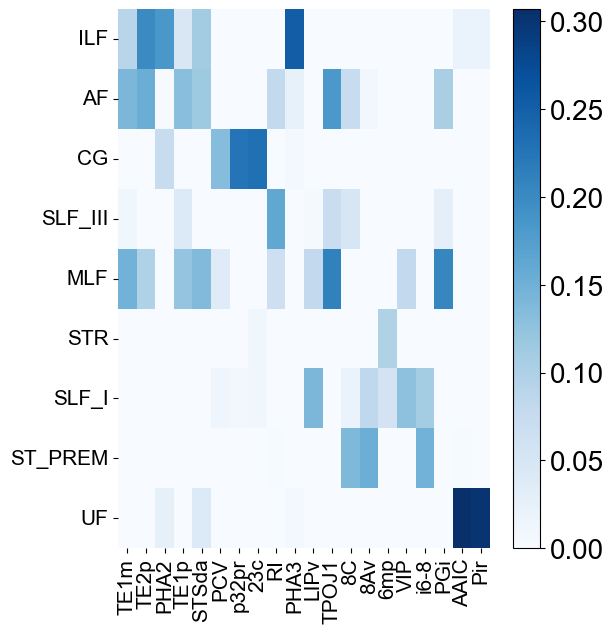

In [93]:
# Glasser
roi_index   = [176,135,154,132,127,26,59,37,103,126,
               47,138,72,66,54,48,96,149,111,109]
fiber_index = [7,0,2,12,4,
               13,10,23,14]

plot_matrix = np.zeros((len(roi_index), len(fiber_index)))
fiber_pname = [label_name_lm[fiber_index[i]] for i in range(len(fiber_index))]
roi_pname   = [roi_namelist[roi_index[i]] for i in range(len(roi_index))]
for i in range(len(roi_index)):
    for k in range(len(fiber_index)):
        plot_matrix[i,k] = fp_atlas[roi_index[i], fiber_index[k]]
df  = pd.DataFrame(plot_matrix.T, index=fiber_pname, columns=roi_pname)
fig = plt.figure(figsize=(6,7))
ax  = fig.add_subplot(111)
fig = sns.heatmap(df, 
                 cmap=plt.get_cmap('Blues'),
                 cbar=False)
cb = fig.figure.colorbar(fig.collections[0]) #显示colorbar
cb.ax.tick_params(labelsize=20) #设置colorbar刻度字体大小
ax.tick_params(labelsize=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha = 'center')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha = 'right')
fig = fig.get_figure()
plt.title(f'', fontsize=20)
plt.savefig(f'./figure4_fiberDecoding_Glasser.png', transparent = True, bbox_inches = 'tight',dpi = 700, format='png')
plt.show()

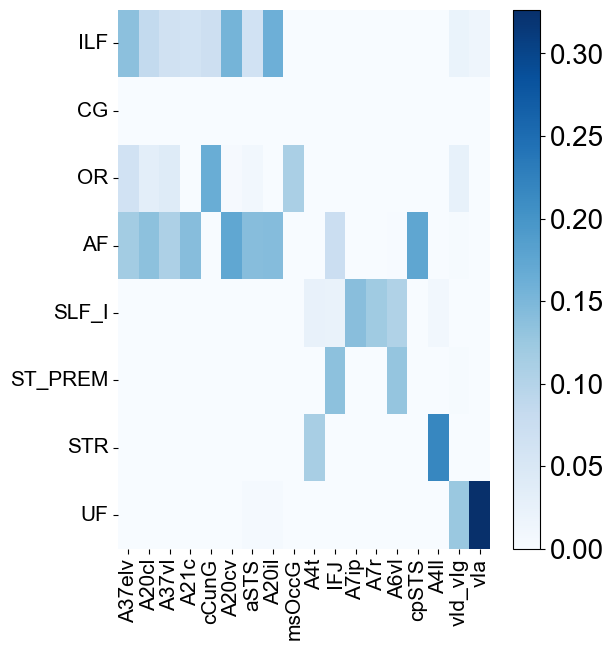

In [350]:
# BNA
roi_index   = [82,84,33,61,12,62,66, 8,29,
               103,47,43,50,96,40,48,49,45][::-1]
fiber_index = [14,13,23,10,
               0,8,2,7][::-1]

plot_matrix = np.zeros((len(roi_index), len(fiber_index)))
fiber_pname = [label_name_lm[fiber_index[i]] for i in range(len(fiber_index))]
roi_pname   = [roi_namelist[roi_index[i]] for i in range(len(roi_index))]
for i in range(len(roi_index)):
    for k in range(len(fiber_index)):
        plot_matrix[i,k] = fp_atlas[roi_index[i], fiber_index[k]]
df  = pd.DataFrame(plot_matrix.T, index=fiber_pname, columns=roi_pname)
fig = plt.figure(figsize=(6,7))
ax  = fig.add_subplot(111)
fig = sns.heatmap(df, 
                 cmap=plt.get_cmap('Blues'),
                 cbar=False)
cb = fig.figure.colorbar(fig.collections[0]) #显示colorbar
cb.ax.tick_params(labelsize=20) #设置colorbar刻度字体大小
ax.tick_params(labelsize=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha = 'center')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha = 'right')
fig = fig.get_figure()
plt.title(f'', fontsize=20)
plt.savefig(f'./figure4_fiberDecoding.png', transparent = True, bbox_inches = 'tight',dpi = 700, format='png')
plt.show()

# Figure 4B.

In [33]:
# read the idx info
dirc_L = '/n02dat01/users/dyli/Atlas/metric_index_L.txt'
select_ind_L = np.loadtxt( dirc_L ).astype(int)
dirc_R = '/n02dat01/users/dyli/Atlas/metric_index_R.txt'
select_ind_R = np.loadtxt( dirc_R ).astype(int)

# Glasser Atlas
atlas_path = '/n02dat01/users/dyli/Atlas/Q1-Q6_RelatedValidation210.CorticalAreas_dil_Final_Final_Areas_Group_Colors.32k_fs_LR.dlabel.nii'
atlas = nib.load(atlas_path)
atlas_data = atlas.get_fdata()
atlas_data = np.squeeze(atlas_data) #(59412,)

neuromap_father='/n02dat01/users/dyli/Grad_data/support_data/neuromaps-data/32k'
name = 'fcgradient02'
neuromap = np.zeros(int(29696+29716))
neuromap_ = surface.load_surf_data(f'{neuromap_father}/{name}.32k.L.func.gii')
neuromap[0:29696] = neuromap_[select_ind_L]
neuromap_ = surface.load_surf_data(f'{neuromap_father}/{name}.32k.R.func.gii')
neuromap[29696:int(29696+29716)] = neuromap_[select_ind_R]

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [34]:
np.unique(atlas_data[0:29696])

array([181., 182., 183., 184., 185., 186., 187., 188., 189., 190., 191.,
       192., 193., 194., 195., 196., 197., 198., 199., 200., 201., 202.,
       203., 204., 205., 206., 207., 208., 209., 210., 211., 212., 213.,
       214., 215., 216., 217., 218., 219., 220., 221., 222., 223., 224.,
       225., 226., 227., 228., 229., 230., 231., 232., 233., 234., 235.,
       236., 237., 238., 239., 240., 241., 242., 243., 244., 245., 246.,
       247., 248., 249., 250., 251., 252., 253., 254., 255., 256., 257.,
       258., 259., 260., 261., 262., 263., 264., 265., 266., 267., 268.,
       269., 270., 271., 272., 273., 274., 275., 276., 277., 278., 279.,
       280., 281., 282., 283., 284., 285., 286., 287., 288., 289., 290.,
       291., 292., 293., 294., 295., 296., 297., 298., 299., 300., 301.,
       302., 303., 304., 305., 306., 307., 308., 309., 310., 311., 312.,
       313., 314., 315., 316., 317., 318., 319., 320., 321., 322., 323.,
       324., 325., 326., 327., 328., 329., 330., 33

In [35]:
neuromap_atlas = np.array([np.sum(neuromap[atlas_data==(i+1)], axis=0)/len(np.argwhere(atlas_data==(i+1))) for i in range(360)])
assert neuromap_atlas.shape[0] == 360
# atlas_data: (59412,)
neuromap_atlas_59412 = np.zeros(59412)
for ii in range(59412):
    neuromap_atlas_59412[ii] = neuromap_atlas[int(atlas_data[ii]-1)]

In [52]:
neuromap_atlas_idx = np.argsort(neuromap_atlas)
neuromap_atlas_sorted = neuromap_atlas[neuromap_atlas_idx]
sensory_idx = neuromap_atlas_idx[0:75]
asso_idx = neuromap_atlas_idx[75:321] # 246
motor_idx = neuromap_atlas_idx[321:360] # 39

sensory_idx_ = sensory_idx[sensory_idx>=180]
asso_idx_ = asso_idx[asso_idx>=180]
motor_idx_ = motor_idx[motor_idx>=180]
sm_idx_ = list(sensory_idx_) + list(motor_idx_)

In [53]:
exp_name = 'test'
# read the decoupling index pattern
C = np.load(f'/n01dat01/dyli/multi/results_data/decoupling_index/HCP40_white_{exp_name}_NC_C_10.npy')
C_norm = np.linalg.norm(C, axis=1)
D = np.load(f'/n01dat01/dyli/multi/results_data/decoupling_index/HCP40_white_{exp_name}_NC_D_10.npy')
D_norm = np.linalg.norm(D, axis=1)
data_L_vertex = D_norm / C_norm
data_L_vertex[np.isnan(data_L_vertex)]=0

emb_G1 = np.zeros(59412)
emb_G1[0:29696] = data_L_vertex[select_ind_L]
emb_G1[29696:59412] = np.zeros(29716)
emb_G1_atlas = np.array([np.sum(emb_G1[atlas_data==(i+1)], axis=0)/len(np.argwhere(atlas_data==(i+1))) for i in range(360)])
emb_G1_atlas[emb_G1_atlas==0] = np.nan

emb_G1_sensory = emb_G1_atlas[sensory_idx_]
emb_G1_asso = emb_G1_atlas[asso_idx_]
emb_G1_motor = emb_G1_atlas[motor_idx_]
emb_G1_sm = emb_G1_atlas[sm_idx_]
print(emb_G1_sensory.shape, emb_G1_asso.shape, emb_G1_motor.shape, emb_G1_sm.shape)

(39,) (121,) (20,) (59,)


/tmp/ipykernel_2921/678897415.py:7: RuntimeWarning: invalid value encountered in divide
  data_L_vertex = D_norm / C_norm


In [48]:
np.savetxt('./Ratio_vertex.txt', data_L_vertex)

In [47]:
np.savetxt('./Ratio_Glasser.txt', emb_G1_atlas)

In [77]:
import re
import sys
import pandas as pd
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# read the brain map name list
result=[]
with open('/n02dat01/users/dyli/Grad_data/support_data/neuromap_name.txt','r') as f:
	for line in f:
		result.append(list(line.strip('\n').split(',')))
name_list = [result[i][0] for i in range(len(result))]

# read the basic info
dirc_L = '/n02dat01/users/dyli/Atlas/metric_index_L.txt'
select_ind_L = np.loadtxt( dirc_L ).astype(int)
dirc_R = '/n02dat01/users/dyli/Atlas/metric_index_R.txt'
select_ind_R = np.loadtxt( dirc_R ).astype(int)

atlas_name='Glasser'
exp_name = 'test'
if atlas_name == 'Scharfer400':
    region_num = 200
    # read the Yeo Atlas
    atlas_path = '/n02dat01/users/dyli/Atlas/Schaefer2018_400Parcels_17Networks_order.dlabel.nii'
    atlas = nib.load(atlas_path)
    atlas_data_ = atlas.get_fdata()
    atlas_data = np.squeeze(atlas_data_)[0:32492]
elif atlas_name == 'Glasser':
    region_num = 180
    # read the Glasser Atlas
    atlas_path = '/n02dat01/users/dyli/Atlas/Glasser_fs_LR32k.L.func.gii'
    atlas_data = surface.load_surf_data(atlas_path)
elif atlas_name == 'BNA':
    region_num=105
    # read the BNA Atlas
    atlas_path = '/n02dat01/users/dyli/Atlas/fsaverage.L.BN_Atlas.32k_fs_LR.label.gii'
    atlas_data = surface.load_surf_data(atlas_path)

# read the decoupling index pattern
C = np.load(f'/n01dat01/dyli/multi/results_data/decoupling_index/HCP40_white_{exp_name}_NC_C_10.npy')
C_norm = np.linalg.norm(C, axis=1)
D = np.load(f'/n01dat01/dyli/multi/results_data/decoupling_index/HCP40_white_{exp_name}_NC_D_10.npy')
D_norm = np.linalg.norm(D, axis=1)
data_L_vertex = D_norm / C_norm
data_L_vertex[np.isnan(data_L_vertex)]=0
if atlas_name == 'BNA': data_L_atlas = np.array([np.sum(data_L_vertex[atlas_data==(2*i+1)], axis=0)/len(np.argwhere(atlas_data==(2*i+1))) for i in range(region_num)])
elif atlas_name == 'Scharfer400': data_L_atlas = np.array([np.sum(data_L_vertex[atlas_data==(i+1)], axis=0)/len(np.argwhere(atlas_data==(i+1))) for i in range(region_num)])
elif atlas_name == 'Glasser': data_L_atlas = np.array([np.sum(data_L_vertex[atlas_data==(i+181)], axis=0)/len(np.argwhere(atlas_data==(i+181))) for i in range(region_num)])
print(data_L_atlas.shape)
assert ~np.isnan(data_L_atlas).any()


(180,)


/tmp/ipykernel_123836/2048216641.py:46: RuntimeWarning: invalid value encountered in divide
  data_L_vertex = D_norm / C_norm


In [34]:
data_L_atlas.shape

(180,)

In [80]:
label = np.loadtxt('./CAB-NP_network_label.txt')
core = np.array([145,144,149,63,43,97,73,80,83,85,111]).astype(np.int16)
peri = np.array([89,170,77,171,91,78,98,179,62,169,15,50,95,117,151,133,177]).astype(np.int16)

df = pd.DataFrame(columns=['model type', 'High-low frequency ratio'])
for ii in range(180):
    #add row to end of DataFrame
    if label[ii]==1 or label[ii]==2 or label[ii]==3 or label[ii]==8:
        df.loc[len(df.index)] = ['SMN & VIS & AUD', data_L_atlas[ii]]
    elif (ii in core) or (ii in peri): 
        df.loc[len(df.index)] = ['MDN', data_L_atlas[ii]]

In [79]:
import statsmodels.stats.weightstats as st
from statannotations.Annotator import Annotator

def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SMN & VIS & AUD vs. MDN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.855e-03 U_stat=4.030e+02


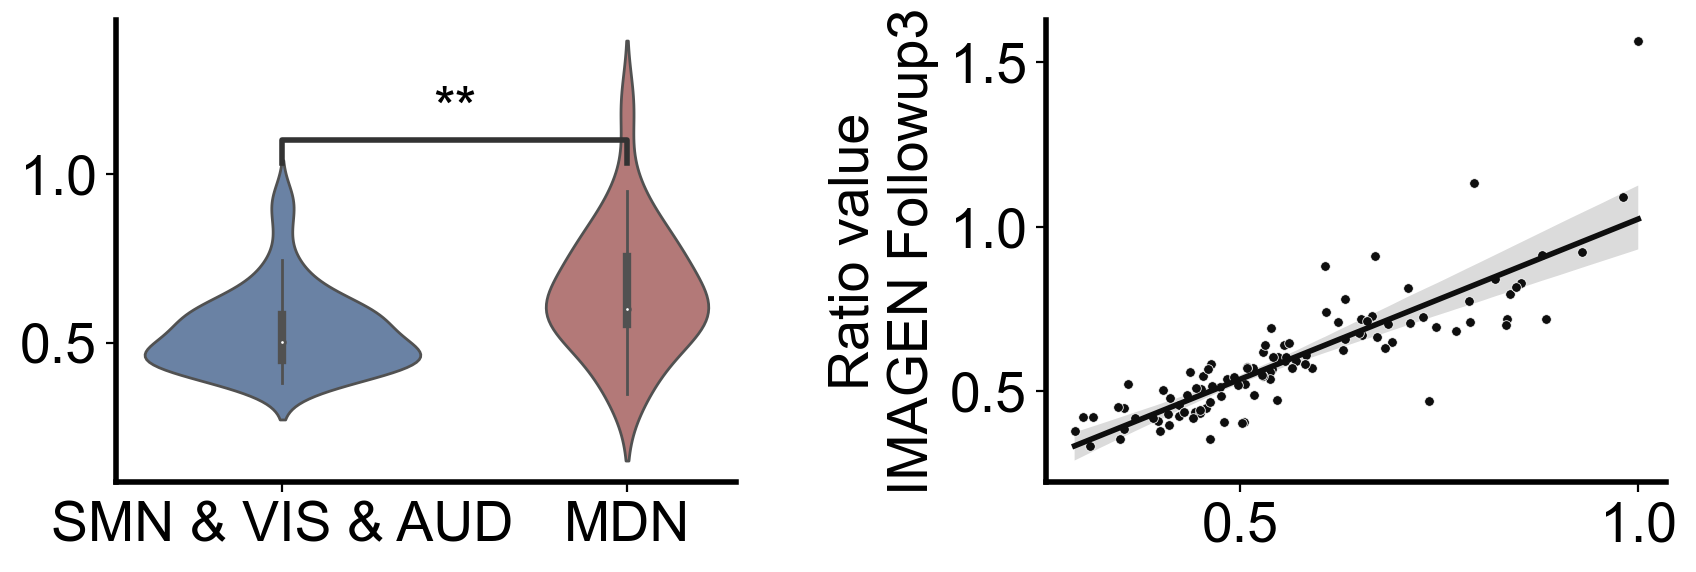

In [81]:
fig = plt.figure(figsize=(10,3), dpi=200)
fig.subplots_adjust(wspace=0.5)

ax = fig.add_subplot(121)
sns.violinplot(x='model type', y='High-low frequency ratio', 
            data=df,
            size=1,
            palette=['#6181ad','#bd706e'],
            order=['SMN & VIS & AUD','MDN'],
            linewidth=1,
            jitter=True)
# ttest
pairs = [('SMN & VIS & AUD','MDN')]
annotator = Annotator(ax, pairs, data=df, x='model type', y='High-low frequency ratio',order=['SMN & VIS & AUD','MDN'])
annotator.configure(test='Mann-Whitney', text_format='star',line_height=0.05, line_width=2,fontsize=20)
annotator.apply_and_annotate()

plt.xlabel('', fontsize=20)
plt.ylabel('', fontsize=20)
plt.xticks(rotation=0)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(labelsize=20)
fig = fig.get_figure()

np.corrcoef(np.loadtxt('./Ratio_Glasser.txt'), np.loadtxt('./Ratio_FU3_Glasser.txt'))
x1 = np.loadtxt('./Ratio_BNA.txt')
x2 = np.loadtxt('./Ratio_FU3_BNA.txt')

ax = fig.add_subplot(122)
sns.regplot(x=x1, y=x2, order=1, scatter=False, line_kws={'lw':1, 'linewidth':2}, color='#0e0e0e')
sns.scatterplot(x=x1, y=x2, s=12, marker='o', color='#0e0e0e')

plt.xlabel('', fontsize=20)
plt.ylabel('Ratio value\nIMAGEN Followup3', fontsize=20)
plt.xticks(rotation=0)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(labelsize=20)
fig = fig.get_figure()

plt.show()